In [1]:
!pip install transformers datasets




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv


File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv('AirlineTweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df=df[['airline_sentiment','text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

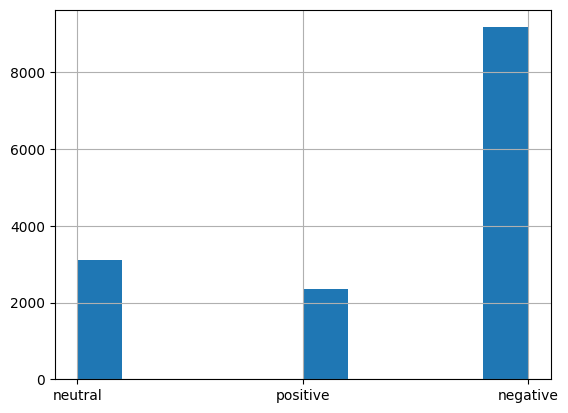

In [8]:
df['airline_sentiment'].hist()

In [9]:
target_map={'positive':1,'negative':0,'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)

In [10]:
df2=df[['text','target']]
df2.columns=['sentence','label']
df2.to_csv('data.csv',index=None)

In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
from datasets import load_dataset
raw_dataset=load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [14]:
split=raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [16]:
checkpoint='distilbert-base-uncased'


In [17]:
from transformers import AutoTokenizer

In [18]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [19]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [20]:
tokenize_datasets=split.map(tokenize_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [21]:
from transformers import AutoModelForSequenceClassification, Trainer,TrainingArguments

In [22]:
model=AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
! pip install torchinfo

In [24]:
from torchinfo import summary

In [25]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [26]:
pip install accelerate -U

In [27]:
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

In [50]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=1)
  acc=np.mean(predictions==labels)
  f1=f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}


In [48]:
trainer=Trainer(
    model,
    training_args,
    train_dataset=tokenize_datasets["train"],
    eval_dataset=tokenize_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [31]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.523500,0.421836,0.831056,0.764531
2,0.339300,0.457868,0.846767,0.790377
3,0.218400,0.584517,0.847222,0.795110


TrainOutput(global_step=1923, training_loss=0.3163577043570024, metrics={'train_runtime': 218.7124, 'train_samples_per_second': 140.568, 'train_steps_per_second': 8.792, 'total_flos': 357616608764400.0, 'train_loss': 0.3163577043570024, 'epoch': 3.0})

In [32]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [33]:
from transformers import pipeline

In [35]:
pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 2.4 MB/s eta 0:00:00


In [39]:
savedmodel=pipeline('text-classification',model="training_dir/checkpoint-1282",device=0)

In [40]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [41]:
test_pred=savedmodel(split['test']['sentence'])

In [42]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9676262140274048},
 {'label': 'LABEL_1', 'score': 0.9638961553573608},
 {'label': 'LABEL_0', 'score': 0.8680119514465332},
 {'label': 'LABEL_1', 'score': 0.9168580770492554},
 {'label': 'LABEL_0', 'score': 0.5520818829536438},
 {'label': 'LABEL_0', 'score': 0.9956477284431458},
 {'label': 'LABEL_2', 'score': 0.7043265700340271},
 {'label': 'LABEL_2', 'score': 0.8287593722343445},
 {'label': 'LABEL_2', 'score': 0.6819378137588501},
 {'label': 'LABEL_0', 'score': 0.9960983991622925},
 {'label': 'LABEL_0', 'score': 0.9884842038154602},
 {'label': 'LABEL_0', 'score': 0.9952163696289062},
 {'label': 'LABEL_1', 'score': 0.9751344919204712},
 {'label': 'LABEL_0', 'score': 0.9961739182472229},
 {'label': 'LABEL_2', 'score': 0.9650008082389832},
 {'label': 'LABEL_1', 'score': 0.9025689959526062},
 {'label': 'LABEL_0', 'score': 0.707197368144989},
 {'label': 'LABEL_0', 'score': 0.9960876703262329},
 {'label': 'LABEL_0', 'score': 0.975492000579834},
 {'label': 'LA

In [66]:
def get_label(d):
  return int(d['label'].split('_')[1])
  test_pred=[get_label[d] for d in test_pred]


In [73]:
test_pred=savedmodel("this is so bad")

In [61]:
print(test_pred)

[{'label': 'LABEL_0', 'score': 0.9798411130905151}]


In [62]:
test_pred=savedmodel("this is so good")
print(test_pred)

[{'label': 'LABEL_1', 'score': 0.9712166786193848}]


In [76]:
test_pred=savedmodel("i'm ok")
print(test_pred)

[{'label': 'LABEL_2', 'score': 0.7449373006820679}]
